# Workshop 3: Computer Vision with CNNs 👀

- **When**: Monday Week 6, 17:00 - 18:30 
- **Where**: AT 5.04
- **Contact**: hello@edinburghai.org
- **Credits**: This notebook is created by EdinburghAI for use in its workshops. If you plan to use it, please credit us. 

## Today
1. Understand what a **convolutional layer** is and its configurable parameters.
2. Train your own image classifier! 🖼️ 
3. Facial segmentation🥸 of *your own face* with a pre-trained model. This one is fun and shouldn't take very long!

Let's get started! 💯

## 1. The Convolutional Layer

A convolutional layer is like a double for loop ➿ over an image. At every location in the image 🖼️, it tries to detect some feature, like whether there is a vertical edge there, or if there's a blob of red 🟥, or if there's a square there or lots of other sorts of things. At the end, we get a new 'image' with big values where there is an edge, and smaller values where there isn't.

It does this using a *kernel*. The kernel of the convolution is the part that decides whether or not the feature is there. Really, the kernel is just another *tensor* (remember what a tensor is?). For grayscale images, we normally think of a kernel as being 2D, which is nice because they're easy to visualise! Generally, our kernels are square of size $n\times n$, where we can decide how big they should be.

You can learn why it's called a *convolution* from 3Blue1Brown [here](https://www.youtube.com/watch?v=KuXjwB4LzSA). TLDR: It's a mathematical operation where you slide one set of numbers (.e.g. our image) over another (e.g. our *kernel*), cross-multiply and add up the results.

**Think**🤔: What do you think the dimensionality of a kernel that takes an RGB image as input is? **Extension😈**: What about a kernel that takes some time-series data as input?

**Think** 🤔: What do you think the following kernels do?

In [1]:
kernel1 = [[-1, 0, 1],
           [-1, 0, 1],
           [-1, 0, 1]]

# Why do you think I've set the middle column to be 2s in the example below? (What do you think the kernel is trying to do? What would happen if they were 1s and you ran this kernel over a uniform wall?)
kernel2 = [[-1, 2, -1],
           [-1, 2, -1],
           [-1, 2, -1]]

kernel3 = [[-1, -1, -1],
           [-1, 1, 1],
           [-1, 1, 1]]

kernel4 = [[1, 1, 1],
           [1, 1, 1],
           [1, 1, 1]]

# Extension😈: This is a bit tougher as it's now 3D!
kernel5 = [
            [
                [-1, -1, -1],
                [-1, -1, -1],
                [2, 2, 2]
            ],
            [
                [-1, -1, -1],
                [2, 2, 2],
                [-1, -1, -1]
            ],
            [
                [2, 2, 2],
                [-1, -1, -1],
                [-1, -1, -1]
            ]
        ]

We can create a 2-dimensional convolutional layer in Pytorch using `torch.nn.conv2d()`. The '2-dimensional' means we are going to run a double for loop over the input - but we can still run this on an RGB image, try to imagine how!

Conv2d takes several parameters:
- `in_channels`: the number of dimensions we are going to double for loop over. E.g. gor a grayscale this would be 1, but for an RGB images this would be 3.
- `out_channels`: A convolutional layer actually consists of many kernels, each responsible for something different e.g. vertical edges, horizontal edges, bright patches, dark patches etc. The number of output channels is the number of kernels in the layer and hence the number of different features we want to learn.
- `kernel_size`: A kernel is $n\times n$ and here is where we choose $n$. (technically $n\times n \times \textnormal{input\_channels}$: **Think🤔**: Why?)

There are 2 other parameters of note: `stride` and `padding`. Perhaps you can guess what they do by the name, but you'll figure out what they do in one of the coming exercises. There are other parameters, but they're less important. I'll leave you to read about them [in the docs](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) if you like.

First let's see a basic conv layer in action.


In [2]:
# Let's import torch as well as the nn module
import torch
from torch import nn

# A convoloutional layer with a single input channel and a single output channel, with kernel size 2
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)

# We can print the kernel
print(conv_layer.weight.data)

tensor([[[[ 0.0526,  0.0255],
          [-0.0388,  0.4591]]]])


In [3]:
# Let's set the kernel to detect vertical edges. Ignore the extra dimensions, they're just for batching images and because the out_channels is 1
conv_layer.weight.data = torch.tensor([[
            [[-1, 1],
           [-1, 1]]
           ]]).float()

# Let's set the bias to 0 so that it doesn't affect the output
conv_layer.bias.data = torch.tensor([0.0])

# Here's a 10x10 image with a vertical edge
image = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]).float()

# Let's run the image through the conv layer. We need to add extra dimensions to the image for similar reasons as before
output = conv_layer(image.view(1, 1, 10, 10))
print('Output image: \n', output)
print('='*50)
# We can also print out the 'shape' of the output i.e. the size of each dimension 
print('Output image shape: \n', output.shape)

Output image: 
 tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 2., 0., 0., 0., 0.],
          [0., 0., 0., 0., 2., 0., 0., 0., 0.],
          [0., 0., 0., 0., 2., 0., 0., 0., 0.],
          [0., 0., 0., 0., 2., 0., 0., 0., 0.]]]],
       grad_fn=<ConvolutionBackward0>)
Output image shape: 
 torch.Size([1, 1, 9, 9])


**Think🤔**: Can you understand the output? Is it what you expected? Is the dimensionality of the output the same as the input? Why or why not?

In [4]:
# Let's now change the padding and see what happens
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, padding=1)
conv_layer.weight.data = torch.tensor([[
            [[-1, 1],
           [-1, 1]]
           ]]).float()
conv_layer.bias.data = torch.tensor([0.0])
output = conv_layer(image.view(1, 1, 10, 10))
print('Output image: \n', output)
print('='*50)
print('Output image shape: \n', output.shape)

Output image: 
 tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0., -2.],
          [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0., -2.],
          [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0., -2.],
          [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0., -2.],
          [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.]]]],
       grad_fn=<ConvolutionBackward0>)
Output image shape: 
 torch.Size([1, 1, 11, 11])


**Think🤔**: What happened? What's the output/shape now? Why might this be a useful feature of a convolution layer?

*Hint: Can you tell what the padding must have done to the input to give you that output? Go have a google if you're struggling.*

**Extension😈**: There's another parameter you can set here on the `conv_layer` called `padding_mode`. Try setting it to `'reflect'`. What do you think will happen to the output?

Let's now look at `stride`.

In [5]:
# Let's now change the stride and see what happens
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=2)
conv_layer.weight.data = torch.tensor([[
            [[-1, 1],
           [-1, 1]]
           ]]).float()
conv_layer.bias.data = torch.tensor([0.0])
output = conv_layer(image.view(1, 1, 10, 10))
print('Output image: \n', output)
print('='*50)
print('Output image shape: \n', output.shape)

Output image: 
 tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 2., 0., 0.],
          [0., 0., 2., 0., 0.]]]], grad_fn=<ConvolutionBackward0>)
Output image shape: 
 torch.Size([1, 1, 5, 5])


**Think🤔**: Try changing the stride value to 3 then 4 as well. What is happening? Why might this be useful?

Let's now run it on a real image.

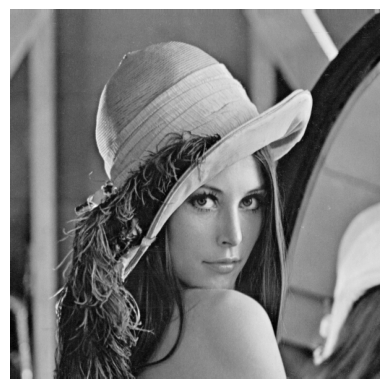

In [7]:
# Let's fetch a real image and display it
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


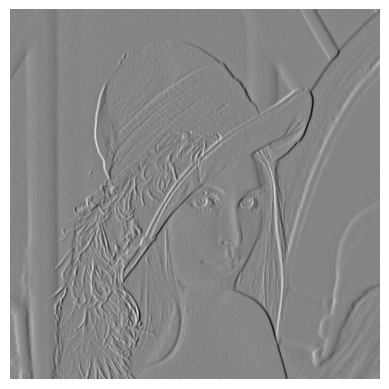

Output image shape: 
 torch.Size([1, 510, 510])


In [8]:
import numpy as np
from torchvision import transforms
import torch.nn as nn

# Let's run our edge detection kernel on the image
# First we need to convert the image to a tensor
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
img_tensor = transform(img)

# Now we can run the image through the conv layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=0, dilation=1)

# Let's set the kernel to detect vertical edges
conv_layer.weight.data = torch.tensor([[
            [[-1, 0, 1],
           [-1, 0, 1],
           [-1, 0, 1]]
           ]]).float()
conv_layer.bias.data = torch.tensor([0.0])

output = conv_layer(img_tensor)
# Print the output as a PIL image
plt.imshow(output.squeeze().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()
print('='*50)
print('Output image shape: \n', output.shape)


**Think🤔**: Did it do what you expect? Try messing around with the kernel to see how the image responds! Try changing the stride and other parameters above! 

When you're happy, we can move on🚀

## 2. The ConvNet Architecture

We've now seen a single convolutional layer, but that's not a full architecture. How is detecting edges useful? Well - imagine you know where all the vertical and horizontal edges are in an image. Maybe you'd have a better guess at where the legs are? Maybe where the nose is? And if you know where the nose and legs are, maybe you can tell where a face and a person is. Or you could tell which kind of animal is in the image. Or maybe you could detect where [cancerous cells in the brain are](https://github.com/adityajn105/brain-tumor-segmentation-unet).

But to do that, we're going to need more than one layer. We take the 'image' output from the previous layer, and plug it in as input to the next layer. The deeper you go in the network, the more abstract the concepts become, because it's combining concepts from the previous layer. 

Remember last week we needed non-linearity of our input so as not to make straight lines? Some similar logic can be applied here, so we apply `ReLU` again. But now we have a much more intuitive reason for using ReLU: Imagine we have run a convolution layer that tries to detect where faces are. Each pixel in the output is a score for how confident we are there is a face at this location. Except, we only really care about the highest scores. Therefore, we can run the ReLU max function to only retain the information about where we are fairly sure there is a face. More theoretically, we represent far more complicated functions with ReLU.

We can also improve speed with 'max pooling'. Don't worry too much about this, as it's less important, and it's not the only way to save on computation. This can be run in Pytorch with [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

You can see all this in action at [the homepage for Stanford's course on Computer Vision.](https://cs231n.stanford.edu/)

Now you're going to build your own ConvNet!🔥

Let's recap how we train neural networks. If you need a better refresher, you can last the notebook from the last workshop.

#### Recap: Steps to Train a NN in Pytorch

Create 
- a neural network
- a loss function
- an optimiser, here you choose the *learning rate*

Train the model:
- Reset the optimiser with `optimiser.zero_grad()`
- Run some data through the model. 
- Calculate the loss
- Backpropagate and calculate gradients with `loss.backward()`
- Update model parameters with `optimiser.step()`
- Repeat

Done!

### Training your own Classifier

Now that we've seen how convolutional layers work and why they're useful, it's time to step things up and train our own classifier! This is where things get exciting: we’re going to take a dataset of satellite images and train a CNN to classify them into different categories. Satellite image classification is used in a ton of real-world applications. For example, in urban planning, satellite images help track how cities are expanding or where new infrastructure needs to be developed. In environmental monitoring, satellite image classification can help track deforestation 🌳, monitor crop health 🌾, or even assess the damage after natural disasters.

We are focusing on a specific challenge: classifying satellite images 🌍 into different land-use categories. We'll be using the UC Merced Land Use Dataset, which contains 2,100 images across 21 classes, ranging from agricultural areas to tennis courts. This section is pretty much plug-and-play. You won't need to write a lot of code, but feel free to play around and change things.

Let's start with importing the images! First, You add the dataset to this notebook. For this:
1. Click "Add Input"
2. Select "Datasets" as filter
3. Search for "UC Merced Land Use Dataset" and add it.


Now let's import the data so we can take a look at it:

In [39]:
# These are the classes in the dataset
CLASSES = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']

from torchvision import datasets, transforms
from torch.utils.data import random_split

# Define the data directory
data_dir = './kaggle/input/UCMerced_LandUse/Images'

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Resize((256, 256))  # Resize images to 128x128
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate sizes for train, validation, and test sets
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Total images: {total_size}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")


Total images: 2100
Training images: 1470
Validation images: 315
Testing images: 315


Let's look at some examples to see what we are working with. This code randomly picks 4 images and displays them with their label. Feel free to run the cell multiple times.

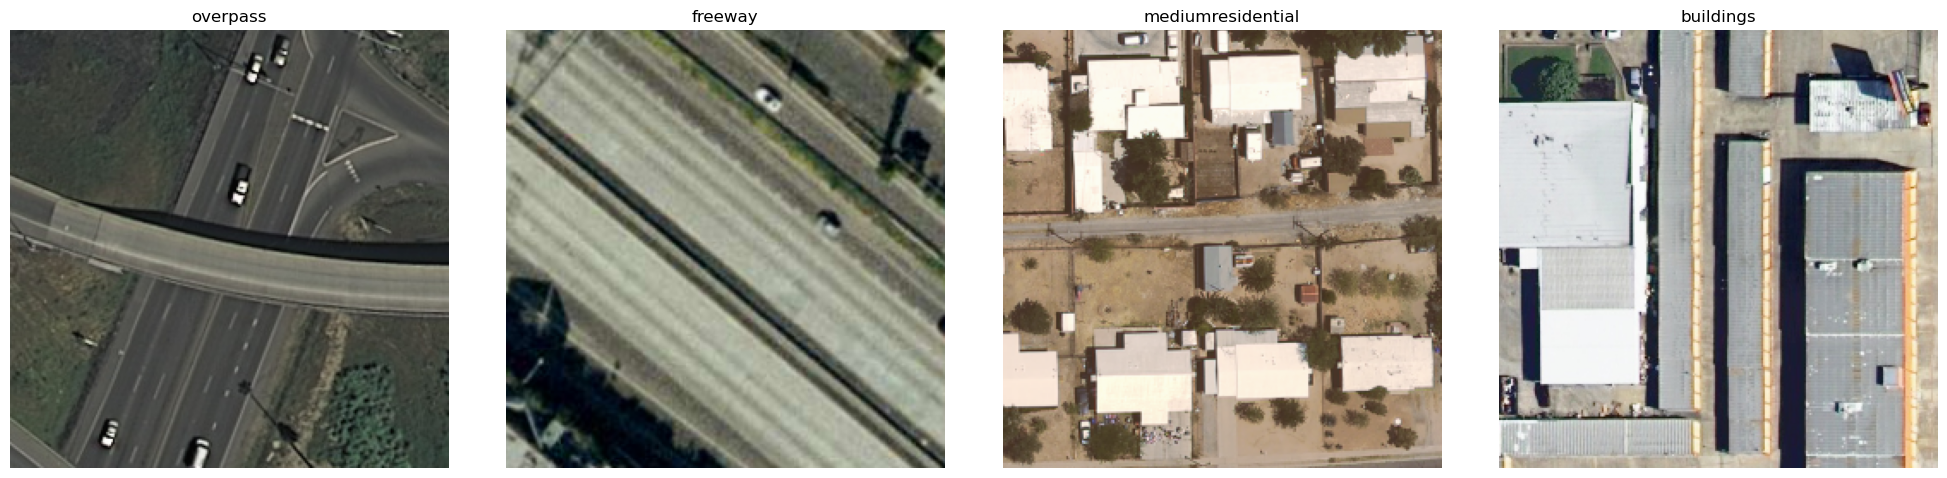

In [40]:
import matplotlib.pyplot as plt
import random

def imshow(img, title=None):
    img = img.permute(1, 2, 0)  # rearrange dimensions for plotting
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Set up the plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.tight_layout()

# Get 4 random indices
random_indices = random.sample(range(len(train_dataset)), 4)

for i, idx in enumerate(random_indices):
    # Get the image and label
    img, label = train_dataset[idx]
    
    # Get the class name
    class_name = CLASSES[label]
    
    # Plot the image
    plt.sca(axs[i])
    imshow(img, title=class_name)

plt.show()

**Think🤔**: What do you think the challenges are for training a classifier on this dataset?

Let's start by setting up a DataLoader, which helps us feed the images to the classifier in a convenient way. We define one each for train, validation and test set.

In [41]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Verify the shape of a batch
for images, labels in train_loader:
    print(f"Shape of image batch: {images.shape} [number of images in the batch, RGB, height, width]")
    print(f"Shape of label batch: {labels.shape} [number of images in the batch]")
    break

Number of batches in train_loader: 46
Number of batches in val_loader: 10
Number of batches in test_loader: 10
Shape of image batch: torch.Size([32, 3, 256, 256]) [number of images in the batch, RGB, height, width]
Shape of label batch: torch.Size([32]) [number of images in the batch]


Now let's define our Convolutional Neural Network. This is a fairly simple architecture, feel free to play around with it.

In [42]:
import torch.nn as nn

# Define the CNN architecture
model = nn.Sequential(
    # Convolutional layer 1
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # Convolutional layer 2
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # Convolutional layer 3
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    # Flatten the output for the fully connected layers
    nn.Flatten(),
    
    # Fully connected layers
    nn.Linear(128 * 32 * 32, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 21)  # 21 output classes as per the UC Merced Land Use Dataset
)

print(model)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=131072, out_features=512, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=512, out_features=21, bias=True)
)


Now lets train the CNN!

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define hyperparameters
num_epochs = 8
learning_rate = 0.001

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_accuracy = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print()

print("Training completed!")

Epoch 1/5: 100%|██████████| 46/46 [02:34<00:00,  3.35s/it]


Epoch 1/5:
Train Loss: 3.0236, Train Accuracy: 5.44%
Val Loss: 2.8878, Val Accuracy: 6.98%



Epoch 2/5: 100%|██████████| 46/46 [02:26<00:00,  3.18s/it]


Epoch 2/5:
Train Loss: 2.8109, Train Accuracy: 12.31%
Val Loss: 2.5986, Val Accuracy: 17.14%



Epoch 3/5: 100%|██████████| 46/46 [02:22<00:00,  3.10s/it]


Epoch 3/5:
Train Loss: 2.4643, Train Accuracy: 22.52%
Val Loss: 2.1610, Val Accuracy: 32.06%



Epoch 4/5: 100%|██████████| 46/46 [02:25<00:00,  3.16s/it]


Epoch 4/5:
Train Loss: 1.9514, Train Accuracy: 38.98%
Val Loss: 1.9856, Val Accuracy: 35.87%



Epoch 5/5: 100%|██████████| 46/46 [02:33<00:00,  3.34s/it]


Epoch 5/5:
Train Loss: 1.5589, Train Accuracy: 50.82%
Val Loss: 1.9362, Val Accuracy: 35.56%

Training completed!


Puh, that took ages to train. Let's look at how well our model does on unseen data (our test-set).

Testing: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Test Loss: 2.0484, Test Accuracy: 33.65%


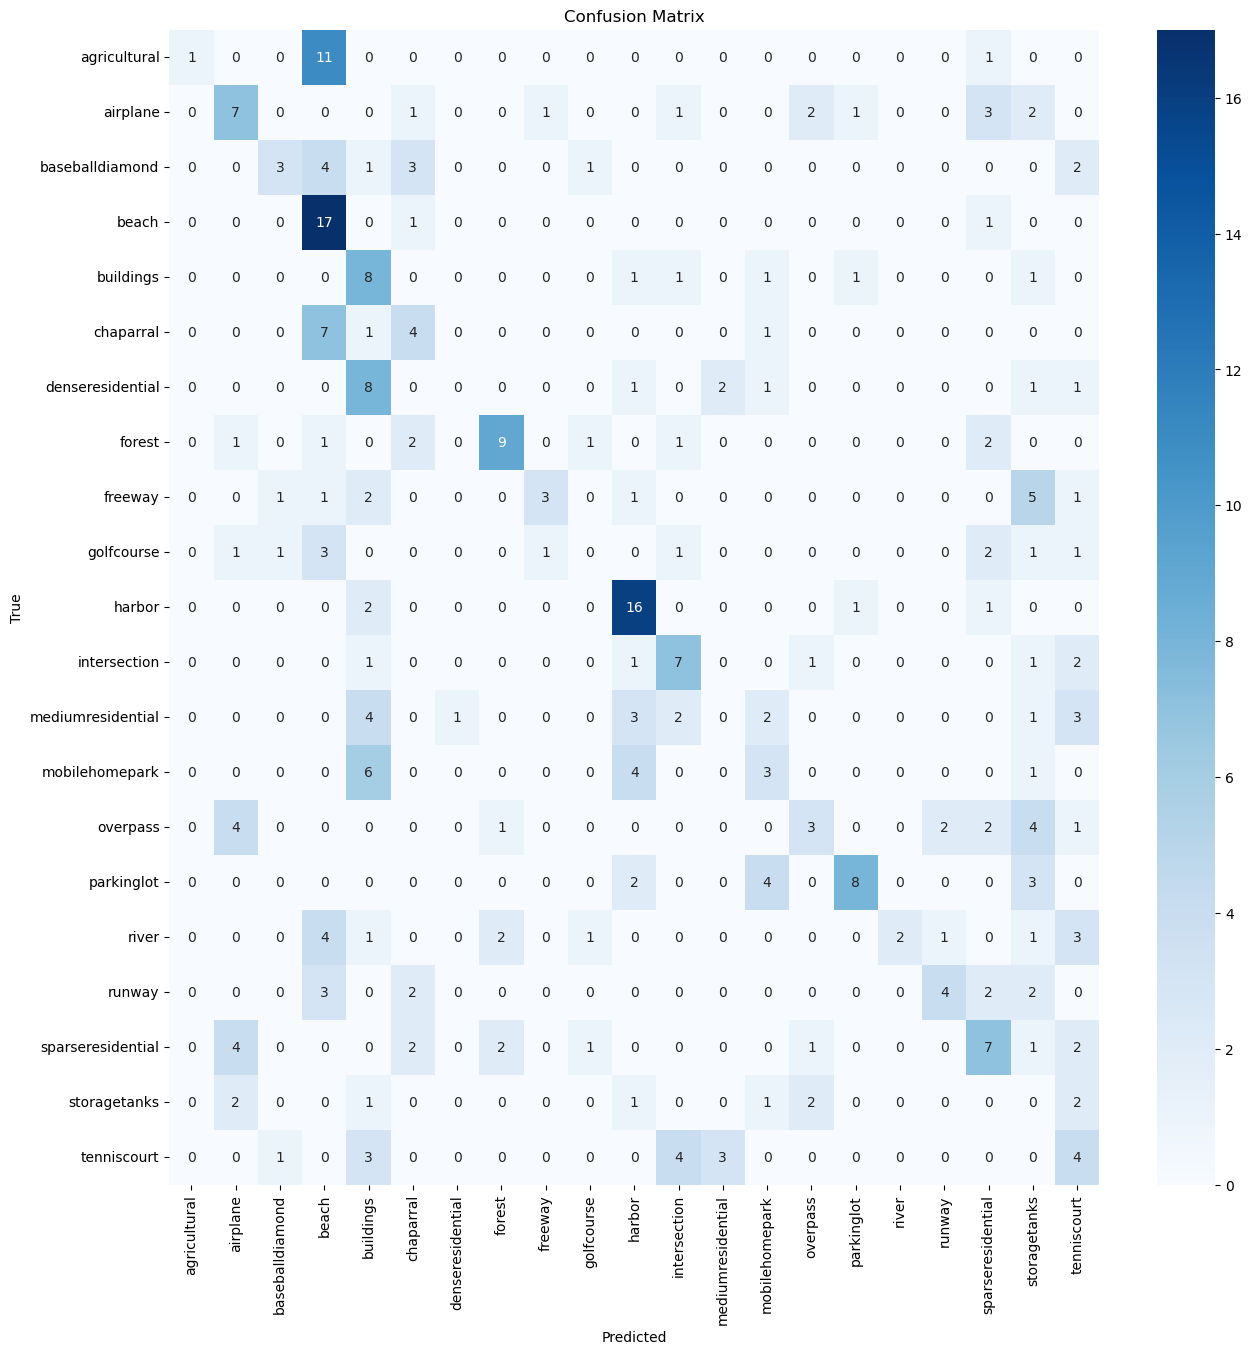

Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      0.08      0.14        13
         airplane       0.37      0.39      0.38        18
  baseballdiamond       0.50      0.21      0.30        14
            beach       0.33      0.89      0.49        19
        buildings       0.21      0.62      0.31        13
        chaparral       0.27      0.31      0.29        13
 denseresidential       0.00      0.00      0.00        14
           forest       0.64      0.53      0.58        17
          freeway       0.60      0.21      0.32        14
       golfcourse       0.00      0.00      0.00        11
           harbor       0.53      0.80      0.64        20
     intersection       0.41      0.54      0.47        13
mediumresidential       0.00      0.00      0.00        16
   mobilehomepark       0.23      0.21      0.22        14
         overpass       0.33      0.18      0.23        17
       parkinglot       0.73    

In [45]:
# Evaluate the model on test data
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
class_names = CLASSES

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Uncomment the following lines to see a more detailed report of model performance
# print("Classification Report:")
# print(classification_report(all_labels, all_predictions, target_names=class_names))

The confusion matrix shows what the true labels are on the y-axis and what our model predicted. 
As you can see, the model does not perform very well. 

**Think🤔**: Can you spot any patterns where the model does well and where it has a hard time distinguishing between classes?

I think we can do a lot better than this! There are several ways we could try to improve the performance. One is to try to define a better model architecture. Since the current model is fairly simple, we would probably need to define something more complex. But then training would take even longer! 

Another option is to use an already trained CNN that is very good at feature detection and just add our own classification head. Lets try to do that instead! We will use [Inception-v3](https://pytorch.org/hub/pytorch_vision_inception_v3/). This is a great option because some people spent a lot of time and money on training it and we can just build on top of that! Just run the cell below and it will take care of training & testing. It will take a while because Inception-V3 is quite big.


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# Load pre-trained Inception v3 model
model = models.inception_v3(pretrained=True)

num_classes = len(CLASSES)

# Add a classification head consisting of 4 layers to the pre-trained model.
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
    )

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        # Inception v3 expects input size of 299x299
        images = nn.functional.interpolate(images, size=(299, 299))
        
        optimizer.zero_grad()
        
        # Inception v3 returns tuple in training mode
        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4*loss2
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Inception v3 expects input size of 299x299
            images = nn.functional.interpolate(images, size=(299, 299))
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%")


print("Training finished!")

# Evaluation
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        images = nn.functional.interpolate(images, size=(299, 299))
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix and Classification Report
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = nn.functional.interpolate(images, size=(299, 299))
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
class_names = CLASSES

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Uncomment the following lines to see a more detailed report of model performance
# print("Classification Report:")
# print(classification_report(all_labels, all_predictions, target_names=class_names))

This version performs A LOT better. Making use of pre-trained models can be very helpful, and a lot of models are available for free directly within Pytorch. You can also check out [HuggingFace](www.huggingface.com), where people share a lot of datasets and pre-trained models that you can use.

## 3. Segment your face!

Let's now use a more advanced model that's already been trained (pre-trained) to segment your own face! The two cells below current fetches an image from online. Try running the cells below.

To use your own custom image (e.g. you), you'll need to upload it to Kaggle and load it in. To do that, under 'Input', click Upload, and upload an image you want to segment. Then name the dataset something like 'my-image', then edit the code in the cell below to load it in.



/Users/vm/miniconda3/envs/CNN_Workshop/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


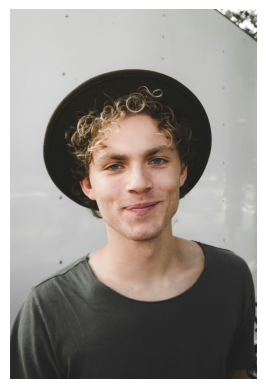

In [10]:
import torch
from torch import nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

from PIL import Image
import matplotlib.pyplot as plt
import requests

# TODO: Comment the code below to load in your own custom image
# This cell loads an image and displays it
url = "https://images.unsplash.com/photo-1539571696357-5a69c17a67c6"
image = Image.open(requests.get(url, stream=True).raw)

# TODO: Uncomment the line below, and edit it to load in your own custom image
# image = Image.open('../input/NAME_OF_DATASET/NAME_OF_FILE_WITH_EXTENSION')

# Show the image
plt.imshow(image)
plt.axis('off')
plt.show()

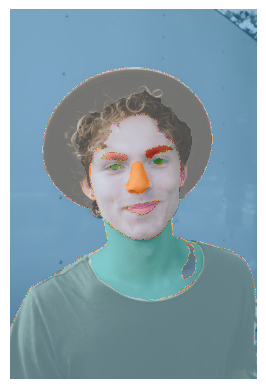

In [11]:
# This cell segments the image using a pretrained model and displays the segmentation. Don't edit the code!

# convenience expression for automatically determining device
device = (
    "cuda"
    # Device for NVIDIA or AMD GPUs
    if torch.cuda.is_available()
    else "mps"
    # Device for Apple Silicon (Metal Performance Shaders)
    if torch.backends.mps.is_available()
    else "cpu"
)

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

# run inference on image
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

# resize output to match input image dimensions
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # H x W
                mode='bilinear',
                align_corners=False)

# get label masks
labels = upsampled_logits.argmax(dim=1)[0]

# move to CPU to visualize in matplotlib
labels_viz = labels.cpu().numpy()
# Show both images with opacity 0.5
plt.imshow(image)
plt.imshow(labels_viz, cmap='tab20', alpha=0.5)
plt.axis('off')
plt.show()

## Computer Vision ✅

> That's it! I hope you can see how cool Convolutions are, and how powerful they are. They're the backbone of lots of what makes machine learning so powerful nowadays. Go and building something cool with them!
> If you want to learn more, go check out [this course at Stanford](https://cs231n.github.io/convolutional-networks/), which has loads more details.
>
> See you next week for some language models and ChatGPT!

Pierre Mackenzie, Edinburgh AI